In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn

import shap


from captum.attr import IntegratedGradients, Deconvolution, GuidedBackprop, DeepLift

In [365]:
train = np.genfromtxt("mnist_train.csv", delimiter = ",", skip_header = 1, dtype=int)/255

# train_y = onehot(train[:,0]*255)
train_y = (train[:,0]*255).astype(int)

train = train[train_y == 0 | (train_y == 1).astype(int)]
train_y = train_y[train_y == 0 | (train_y == 1).astype(int)]

In [366]:
test = np.genfromtxt("mnist_test.csv", delimiter = ",", skip_header = 1, dtype=int)/255
test_y = (test[:,0]*255).astype(int)

test_dat = torch.Tensor(test[test_y == 0 | (test_y == 1).astype(int)])

In [367]:
train_y = torch.tensor(train_y, dtype= torch.long)
train_dat = torch.Tensor(train)


In [368]:
batch_size = 32

In [369]:
def onehot(l):
    one = torch.zeros((l.shape[0],10))

    for i, o in enumerate(l):
        one[i,int(o)] = 1

    return one


def loader(data, data_y, batch_size):
    for i in range(len(data)//batch_size):
        x, y = data[i*batch_size:(i+1)*batch_size,1:], data_y[i*batch_size:(i+1)*batch_size]
        yield x, y


train_loader = loader(train_dat, train_y, batch_size)


In [370]:
class nemt(nn.Module):
    def __init__(self):
        super(nemt, self).__init__()
        self.get_res = False
        self.conv = nn.Conv2d(1, 2, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(288, 64)
        # self.fc1 = lambda x: x
        self.fc2 = lambda x: x
        # self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.conv(x.view(-1,28,28).unsqueeze(1))
        if self.get_res:
            return x
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.fc1(x.reshape(-1,288)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = nemt()


In [371]:
loss_fn = nn.CrossEntropyLoss()

def train(model, n_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

    for i in range(n_epochs):
        train_loader = loader(train_dat, train_y, batch_size)

        running_loss = 0.0
        running_acc = 0.0
        c = 0
        for X, y in tqdm(train_loader, total = len(train_y)//batch_size):
            pred = model(X)
            loss = loss_fn(pred, y)

            acc = (pred.argmax(1) == y).detach().float().mean()

            running_loss += loss.detach().numpy()
            running_acc += acc

            loss.backward()
            optimizer.step()
            c += 1
        print(running_loss/c, running_acc/c)

train(model, 2)

  0%|          | 0/395 [00:00<?, ?it/s]

0.6132519822331923 tensor(0.8044)


  0%|          | 0/395 [00:00<?, ?it/s]

0.39797733128070834 tensor(0.9942)


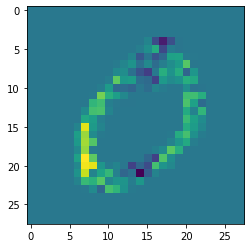

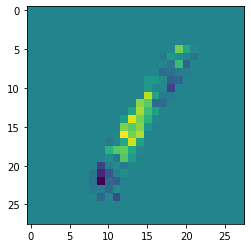

In [10]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
import torchvision


i = 4

X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
pred_label = model(X)

# model = torchvision.models.resnet18(pretrained=True)
# model = model.eval()


for i in range(2):
    # i = 1

    X, y = train_dat[i,1:].unsqueeze(0), train_y[i].unsqueeze(0)
    pred_label = model(X)

    # print(pred_label.shape, X.shape)
    # print(torch.argmax(pred_label), y)
    integrated_gradients = IntegratedGradients(model)

    attributions_ig = integrated_gradients.attribute(X, target=torch.argmax(pred_label))

    v = attributions_ig.squeeze(0).view(28,28).cpu().detach().numpy()
    plt.imshow(v)
    plt.show()
# plt.imshow(v + X.view(28,28).cpu().detach().numpy())
# viz.visualize_image_attr(v,
#                             torch.argmax(y),
#                             method='heat_map',)
#                             # show_colorbar=True,)
# #                             # sign='positive',)
# #                             # outlier_perc=1)

In [347]:
from captum.attr import IntegratedGradients, Deconvolution, GuidedBackprop, DeepLift, LRP

methods = [IntegratedGradients, LRP, DeepLift, GuidedBackprop ]



In [242]:
from scipy.stats import spearmanr

def get_corrs(a):
    A = np.empty((4,4))
    for x in range(4):
        for y in range(4):
            A[x,y] = spearmanr(a[x],a[y])[0] 
    return A

def get_attrs(dat):
    all_attr = []
    for d in dat:
        img = d[1:]
        target = model(img).argmax(1)
        attributions = []

        for m in methods:
            x = m(model)
            attr = x.attribute(img.unsqueeze(0), target=target)
            attributions.append(attr.detach().squeeze(0))
        all_attr.append(attributions)

    return all_attr


all_attr = get_attrs(test_dat)

Input Tensor 0 did not already require gradients, required_grads has been set automatically.
Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished


In [243]:
corrs = [get_corrs(a) for a in all_attr]

Text(0.5, 1.0, 'Spearman correlation between interpretability methods')

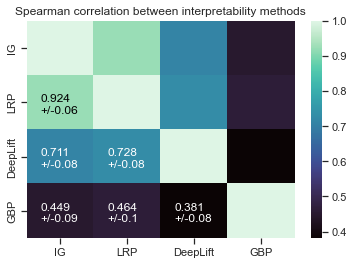

In [344]:
import seaborn as sns;
sns.set_style("ticks")

avg, std = np.array(corrs).mean(axis = 0), np.array(corrs).std(axis = 0)
# plt.imshow(avg)
sns.heatmap(avg, annot= False, cmap = "mako")
x = np.array(range(4))+0.5
plt.xticks(x, labels =  mnames)
plt.yticks(x, labels =  mnames)

from itertools import product


def coords(n):
    return product(range(n), repeat = 2)

for (x,y) in coords(4):
    t = f"{avg[x,y]:.3}\n+/-{std[x,y]:.1}" if y - x > 0 else ""
    # plt.text(x+0.22,y+0.72,t,c = "w")
    # print(f"{avg[x,y]:.3}+/-{std[x,y]:.1}")

    c = "black" if avg[x,y] > 0.8 else "w"
    plt.text(x+0.2,y+0.7,t, c = c)

plt.title("Spearman correlation between interpretability methods")



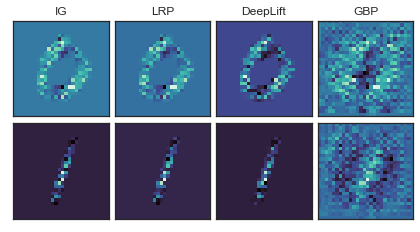

In [ ]:
mnames =  ["IG", "LRP", "DeepLift", "GBP"]


fig, axs = plt.subplots(2,4, sharex="col",sharey="row")

for i in range(4):
    axs[1][i].imshow(all_attr[0][i].reshape((28,28)), cmap = "mako")
    axs[0][i].imshow(all_attr[1][i].reshape((28,28)), cmap = "mako")
    axs[0][i].set_xticks([])
    axs[1][i].set_yticks([])
    axs[0][i].set_yticks([])
    axs[0][i].set_title(mnames[i])



fig.tight_layout(h_pad = -3, w_pad = -0.0)
plt.show()

In [359]:
model.get_res = True

torch.Size([2, 24, 24])
0.045936305


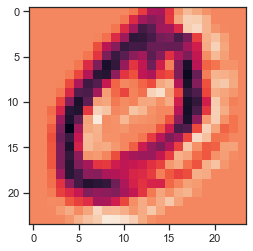

0.34508657


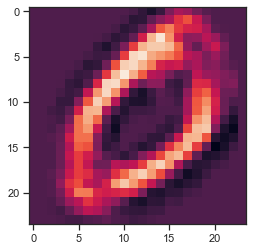

In [362]:
t = train_dat[:32,1:] 
k = 0
# t = torch.Tensor(np.random.random((32,28*28)))
print(res.shape)
for i in range(2):
    plt.imshow(res[i].detach().numpy())
    print(np.mean(res[i].detach().numpy()))
    plt.show()